In [1]:
import os
from glob import glob
import soundfile as sf
import librosa
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ASTForAudioClassification, ASTFeatureExtractor
from torch.nn.utils.rnn import pad_sequence

import splitfolders

import matplotlib.pyplot as plt
from tqdm import tqdm

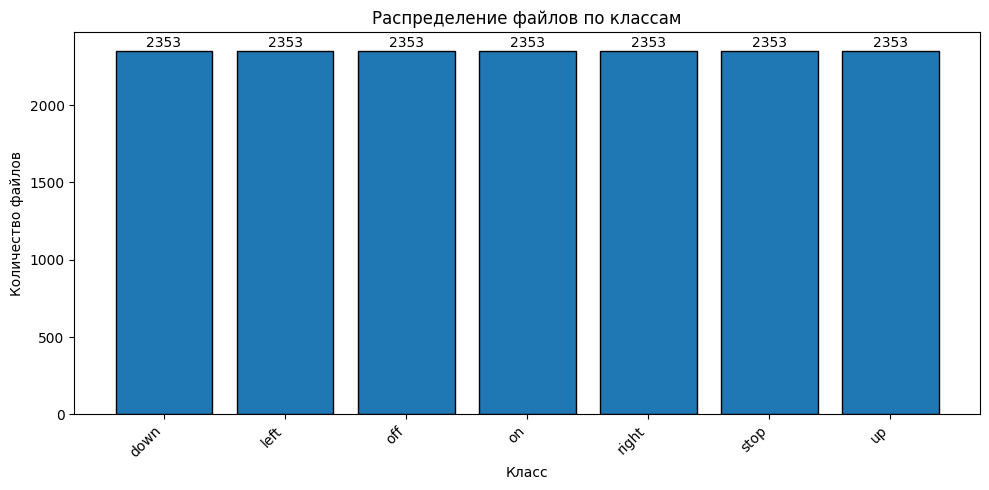

In [2]:
data_dir = 'datasets/speech_commands/'

# проверка распределения по классам
class_counts ={}

for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    count = len([f for f in os.listdir(class_path)])
    class_counts[class_folder] = count

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10, 5))
bars = plt.bar(classes, counts, edgecolor='black')

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             str(count), ha='center', va='bottom', fontsize=10)
    
plt.xlabel('Класс')
plt.ylabel('Количество файлов')
plt.title('Распределение файлов по классам')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

In [16]:
# прооверка, нет ли битых файлов
bad = []

for cls in os.listdir(data_dir):
    for file in tqdm(os.listdir(os.path.join(data_dir, cls)), desc=f'scaning folder {cls}'):
        file_path = os.path.join(data_dir, cls, file)
        if not file_path.lower().endswith('.wav'):
            continue
        try:
            sf.info(file_path)
        except Exception:
            bad.append(file_path)

bad

scaning folder up: 100%|██████████| 2353/2353 [00:19<00:00, 120.12it/s]


[]

In [6]:
os.mkdir('datasets/speech_commands_split/')
splitfolders.ratio('datasets/speech_commands/', output='datasets/speech_commands_split/', ratio=(0.7, 0.15, 0.15))

Copying files: 16471 files [00:18, 868.99 files/s]


___
___

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
label2id = {l: i for i, l in enumerate(classes)}
id2label = {i: l for l, i in label2id.items()}
num_labels = len(classes)

In [ ]:
base_model_id = "MIT/ast-finetuned-speech-commands-v2"

feature_extractor = ASTFeatureExtractor.from_pretrained(base_model_id)

model = ASTForAudioClassification.from_pretrained(
    base_model_id,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)
model.to(device)

In [6]:
TARGET_SR = feature_extractor.sampling_rate

class AudioFolderAST(Dataset):
    def __init__(self, data_dir, target_sr, feature_extractor):
        self.data_dir = data_dir
        self.target_sr = target_sr
        self.feature_extractor = feature_extractor

        self.classes = sorted(
            d.name for d in os.scandir(data_dir) if d.is_dir()
        )
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        self.files = []
        for cls in self.classes:
            pattern = os.path.join(data_dir, cls, "*.wav")
            for path in glob(pattern):
                self.files.append((path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path, label = self.files[idx]
        y, _ = librosa.load(path, sr=self.target_sr, mono=True)

        y = y.astype(np.float32)
        
        inputs = self.feature_extractor(
            y,
            sampling_rate=TARGET_SR,
            return_tensors="pt",
            padding=True,
            truncation=True,
        )

        input_values = inputs["input_values"].squeeze(0)

        return input_values, label

In [7]:
def collate_fn(batch):
    input_values = [b[0] for b in batch]
    labels = torch.tensor([b[1] for b in batch], dtype=torch.long)

    input_values = pad_sequence(input_values, batch_first=True)
    return {'input_values': input_values, 'labels': labels}

data_dir_split = 'datasets/speech_commands_split/'

train_ds = AudioFolderAST(os.path.join(data_dir_split, 'train'), TARGET_SR, feature_extractor)
val_ds = AudioFolderAST(os.path.join(data_dir_split, 'val'), TARGET_SR, feature_extractor)
test_ds = AudioFolderAST(os.path.join(data_dir_split, 'test'), TARGET_SR, feature_extractor)

In [8]:
import random
from collections import defaultdict

def subset_per_class(dataset, max_per_class=1000, seed=42):
    random.seed(seed)
    by_class = defaultdict(list)
    for idx, (_, label) in enumerate(dataset.files):
        by_class[label].append(idx)

    keep_indices = []
    for label, idxs in by_class.items():
        if len(idxs) > max_per_class:
            idxs = random.sample(idxs, max_per_class)
        keep_indices.extend(idxs)

    subset = torch.utils.data.Subset(dataset, keep_indices)
    return subset

train_ds = subset_per_class(train_ds, max_per_class=500)
val_ds = subset_per_class(val_ds, max_per_class=150)
test_ds = subset_per_class(test_ds, max_per_class=150)

In [9]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=16, collate_fn=collate_fn)

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for batch in tqdm(loader, desc='Train: '):
        input_values = batch["input_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_values=input_values, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    print(f'    train_loss={total_loss/len(loader):.4f}, train_acc={correct/total:.3f}')


def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in tqdm(loader, desc='Val: '):
            input_values = batch["input_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_values=input_values, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f'    val_loss={total_loss/len(loader):.4f}, val_acc={correct/total:.3f}')

In [11]:
train_one_epoch(model, train_loader, optimizer)
evaluate(model, val_loader)

Train: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s]


    train_loss=0.1259, train_acc=0.965


Val: 100%|██████████| 66/66 [00:15<00:00,  4.29it/s]

    val_loss=0.0692, val_acc=0.973


In [13]:
from sklearn.metrics import classification_report

In [ ]:
model.eval()
total_loss = 0.0
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Val: '):
        input_values = batch["input_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_values=input_values, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

avg_loss = total_loss / len(test_loader)
accuracy = correct / total

In [14]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       150
           1       0.97      0.99      0.98       150
           2       0.99      0.97      0.98       150
           3       0.99      0.99      0.99       150
           4       0.99      0.99      0.99       150
           5       0.99      0.99      0.99       150
           6       1.00      0.96      0.98       150

    accuracy                           0.98      1050
   macro avg       0.98      0.98      0.98      1050
weighted avg       0.98      0.98      0.98      1050

